![](https://scikit-learn.org/stable/_images/grid_search_workflow.png)

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
import numpy as np
import pandas as pd

import pickle

from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, matthews_corrcoef, precision_recall_curve, auc

from keras.utils import np_utils

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD

import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring
from skorch.callbacks import TensorBoard
from skorch.helper import predefined_split

In [30]:
# import configurations (file paths, etc.)
import yaml
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper
    
configFile = '../cluster/data/medinfmk/ddi/config/config.yml'

with open(configFile, 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=Loader)

In [31]:
pathInput = cfg['filePaths']['dirRaw']
pathOutput = cfg['filePaths']['dirProcessed']
# path to store python binary files (pickles)
# in order not to recalculate them every time
pathPickles = cfg['filePaths']['dirProcessedFiles']['dirPickles']
pathRuns = cfg['filePaths']['dirProcessedFiles']['dirRuns']
pathPaperScores = cfg['filePaths']['dirRawFiles']['paper-individual-metrics-scores']
datasetDirs = cfg['filePaths']['dirRawDatasets']
DS1_path = str(datasetDirs[0])

# Helper Functions

In [32]:
def prepare_data(input_fea, input_lab, seperate=False):
    offside_sim_path = input_fea
    drug_interaction_matrix_path = input_lab
    drug_fea = np.loadtxt(offside_sim_path,dtype=float,delimiter=",")
    interaction = np.loadtxt(drug_interaction_matrix_path,dtype=int,delimiter=",")
    
    train = []
    label = []
    tmp_fea=[]
    drug_fea_tmp = []
            
    for i in range(0, (interaction.shape[0]-1)):
        for j in range((i+1), interaction.shape[1]):
            label.append(interaction[i,j])
            drug_fea_tmp_1 = list(drug_fea[i])
            drug_fea_tmp_2 = list(drug_fea[j])
            if seperate:
                 tmp_fea = (drug_fea_tmp_1,drug_fea_tmp_2)
            else:
                 tmp_fea = drug_fea_tmp_1 + drug_fea_tmp_2
            train.append(tmp_fea)

    return np.array(train), np.array(label)

In [33]:
def transfer_array_format(data):
    formated_matrix1 = []
    formated_matrix2 = []
    for val in data:
        formated_matrix1.append(val[0])
        formated_matrix2.append(val[1])
    return np.array(formated_matrix1), np.array(formated_matrix2)

In [34]:
def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
        y = encoder.transform(labels).astype(np.int32)
    if categorical:
        y = np_utils.to_categorical(y)
    return y, encoder

In [35]:
def preprocess_names(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    if categorical:
        labels = np_utils.to_categorical(labels)
    return labels, encoder

In [36]:
def getStratifiedKFoldSplit(X,y,n_splits):
    skf = StratifiedKFold(n_splits=n_splits, random_state=42)
    return skf.split(X,y)

In [37]:
class NDD(nn.Module):
    def __init__(self, D_in=1096, H1=300, H2=400, D_out=2, drop=0.5):
        super(NDD, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(D_in, H1) # Fully Connected
        self.fc2 = nn.Linear(H1, H2)
        self.fc3 = nn.Linear(H2, D_out)
        self.drop = nn.Dropout(drop)
        self._init_weights()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x
    
    def _init_weights(self):
        for m in self.modules():
            if(isinstance(m, nn.Linear)):
                m.weight.data.normal_(0, 0.05)
                m.bias.data.uniform_(-1,0)

In [38]:
def updateSimilarityDFSingleMetric(df, sim_type, metric, value):
    df.loc[df['Similarity'] == sim_type, metric ] = round(value,3)
    return df

In [39]:
def updateSimilarityDF(df, sim_type, AUROC, AUPR, F1, Rec, Prec):
    df = updateSimilarityDFSingleMetric(df, sim_type, 'AUC', AUROC)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'AUPR', AUPR)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'F-measure', F1)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'Recall', Rec)
    df = updateSimilarityDFSingleMetric(df, sim_type, 'Precision', Prec)
    return df

In [40]:
def getNetParamsStr(net, str_hidden_layers_params, net_params_to_print=["max_epochs", "batch_size"]):
    net_params = [val for sublist in [[x,net.get_params()[x]] for x in net_params_to_print] for val in sublist]
    net_params_str = '-'.join(map(str, net_params))
    return(net_params_str+str_hidden_layers_params)

In [41]:
def writeReplicatedIndividualScoresCSV(net, df, destination, str_hidden_layers_params):
    filePath = destination + "replicatedIndividualScores_" + getNetParamsStr(net, str_hidden_layers_params) + ".csv"
    df.to_csv(path_or_buf = filePath, index=False)

In [42]:
def getNDDClassifier(D_in, H1, H2, D_out, drop, Xy_test):
    model = NDD(D_in, H1, H2, D_out, drop)
    
    net = NeuralNetClassifier(
        model,
        criterion=nn.CrossEntropyLoss,
        max_epochs=20,
        optimizer=SGD,
        optimizer__lr=0.01,
        optimizer__momentum=0.9,    
        optimizer__weight_decay=1e-6,    
        optimizer__nesterov=True,    
        batch_size=200,
        callbacks=callbacks,
        # Shuffle training data on each epoch
        iterator_train__shuffle=True,
        device=device,
        train_split=predefined_split(Xy_test),
    )
    return net

In [43]:
def avgMetrics(AUROC, AUPR, F1, Rec, Prec, kfold_nsplits):
    AUROC /= kfold_nsplits
    AUPR /= kfold_nsplits
    F1 /= kfold_nsplits
    Rec /= kfold_nsplits
    Prec /= kfold_nsplits
    return AUROC, AUPR, F1, Rec, Prec

# Run

In [44]:
df_paperIndividualScores = pd.read_csv(pathPaperScores)

df_replicatedIndividualScores = df_paperIndividualScores.copy()
# Copy scores table and set them to 0
for col in df_replicatedIndividualScores.columns:
    if col != 'Similarity':
        df_replicatedIndividualScores[col].values[:] = 0

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
soft = nn.Softmax(dim=1)

In [46]:
do_prepare_data = False
do_train_model = True
kfold_nsplits = 5
similaritiesToRun = df_paperIndividualScores['Similarity']
# similaritiesToRun = ["sideeffect"]

for similarity in similaritiesToRun:
    input_fea = pathInput+DS1_path+"/" + similarity + "_Jacarrd_sim.csv"
    input_lab = pathInput+DS1_path+"/drug_drug_matrix.csv"
    dataPicklePath = pathPickles+"data_X_y_" + similarity + "_Jaccard.p"
    
    # Prepare data if not available
    if do_prepare_data:
        X,y = prepare_data(input_fea, input_lab, seperate = False)

        with open(dataPicklePath, 'wb') as f:
            pickle.dump([X, y], f)

    # Load X,y and split in to train, test
    with open(dataPicklePath, 'rb') as f:
        X, y = pickle.load(f)
    
    X = X.astype(np.float32)
    y = y.astype(np.int64)    
    
    
    # Define model
    D_in, H1, H2, D_out, drop = X.shape[1], 300, 400, 2, 0.5
    str_hidden_layers_params = "-H1-" + str(H1) + "-H2-" + str(H2)
    callbacks = []
    
    AUROC, AUPR, F1, Rec, Prec = 0,0,0,0,0
    kFoldSplit = getStratifiedKFoldSplit(X,y,n_splits=kfold_nsplits)
    for i, indices in enumerate(kFoldSplit):
        train_index = indices[0]
        test_index = indices[1]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Create Network Classifier
        Xy_test = skorch.dataset.Dataset(X_test, y_test)
        net = getNDDClassifier(D_in, H1, H2, D_out, drop, Xy_test)        
        
        # Fit and save OR load model
        modelPicklePath = pathPickles+"model_params/model_params_fold" + str(i) + "_" + str_hidden_layers_params+ "_" + similarity + ".p"
        if do_train_model:
            net.fit(X_train, y_train)
            net.save_params(f_params=modelPicklePath)
        else:
            net.initialize()  # This is important!
            net.load_params(f_params=modelPicklePath)

        # Make predictions
        y_pred = net.predict(X_test)
        lr_probs = soft(net.forward(X_test))[:,1]
        lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

        AUROC += roc_auc_score(y_test, y_pred)
        AUPR += auc(lr_recall, lr_precision)
        F1 += f1_score(y_test, y_pred)
        Rec += recall_score(y_test, y_pred)
        Prec += precision_score(y_test, y_pred)
        
        print(i, similarity, AUROC, AUPR, F1, Rec, Prec)
        
    
    AUROC, AUPR, F1, Rec, Prec = avgMetrics(AUROC, AUPR, F1, Rec, Prec, kfold_nsplits)
    print(similarity, AUROC, AUPR, F1, Rec, Prec)
    
    # Fill replicated metrics
    updateSimilarityDF(df_replicatedIndividualScores, similarity, AUROC, AUPR, F1, Rec, Prec)
    
# Write CSV
writeReplicatedIndividualScoresCSV(net, df_replicatedIndividualScores, pathRuns, str_hidden_layers_params)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6288       0.6758        0.6280  2.5137
      2        0.6216       0.6758        0.6286  2.4360
      3        0.6162       0.6758        0.6333  2.3867
      4        0.6096       0.6758        0.6331  2.3735
      5        0.6029       0.6803        0.6245  2.4230
      6        0.5970       0.6765        0.6192  2.4200
      7        0.5963       0.6780        0.6232  2.3889
      8        0.5921       0.6917        0.6114  2.3374
      9        0.5940       0.6810        0.6205  2.7024
     10        0.5917       0.6792        0.6158  2.5809
     11        0.5903       0.6775        0.6162  2.4978
     12        0.5954       0.6759        0.6237  2.5894
     13        0.5979       0.6831        0.6178  2.4727
     14        0.5922       0.6809        0.6214  2.5226
     15        0.5949       0.6761        0.6365  2.4232
     16        0.5947       0.6

      8        0.4431       0.7288        0.5839  2.6835
      9        0.4297       0.7266        0.5955  2.4403
     10        0.4185       0.7294        0.5916  2.6645
     11        0.4137       0.7331        0.5960  2.5649
     12        0.4067       0.7291        0.6038  2.5339
     13        0.4002       0.7380        0.5907  2.4311
     14        0.3957       0.7386        0.5876  2.4629
     15        0.3919       0.7340        0.6194  2.5578
     16        0.3882       0.7411        0.6015  2.4309
     17        0.3853       0.7305        0.6290  2.4157
     18        0.3827       0.7362        0.6128  2.3665
     19        0.3793       0.7374        0.6263  2.4221
     20        0.3751       0.7464        0.5941  2.5221
0 target 0.6565979518614613 0.6137976370772845 0.5063636363636363 0.4012555315426572 0.6860812950906211
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6339       0.6758       

      7        0.5462       0.7043        0.6019  2.4270
      8        0.5391       0.7045        0.6069  2.4622
      9        0.5353       0.6958        0.6115  2.4142
     10        0.5310       0.7084        0.6057  2.4120
     11        0.5283       0.7148        0.5942  2.4603
     12        0.5249       0.7157        0.5929  2.3829
     13        0.5214       0.7133        0.5993  2.3863
     14        0.5197       0.7164        0.5950  2.3901
     15        0.5179       0.7172        0.5932  2.3744
     16        0.5158       0.7131        0.5989  2.3756
     17        0.5135       0.7148        0.5965  2.3782
     18        0.5125       0.7186        0.5826  2.4157
     19        0.5113       0.7221        0.5899  2.4187
     20        0.5100       0.7215        0.5835  2.3807
0 transporter 0.6147286663639795 0.5504395027319215 0.4199847126676395 0.3110013378614799 0.6465554129225503
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  

      5        0.5234       0.7194        0.5890  2.4436
      6        0.5090       0.7249        0.5780  2.5653
      7        0.4974       0.7246        0.5772  2.4674
      8        0.4906       0.7174        0.6089  2.4034
      9        0.4824       0.7148        0.6068  2.3777
     10        0.4770       0.7215        0.5733  2.3916
     11        0.4737       0.7184        0.5771  2.3716
     12        0.4681       0.7241        0.5911  2.5683
     13        0.4656       0.7193        0.5812  2.5440
     14        0.4619       0.7136        0.5896  2.4756
     15        0.4601       0.7261        0.5861  2.8922
     16        0.4574       0.7183        0.5787  2.7993
     17        0.4549       0.7210        0.5915  2.5410
     18        0.4529       0.7208        0.6122  2.4961
     19        0.4523       0.7278        0.5925  2.4297
     20        0.4501       0.7264        0.5849  2.3991
0 enzyme 0.6220517469501661 0.5673921355285172 0.43526170798898073 0.3252032520325203 0.

      6        0.5040       0.6858        0.5987  2.4206
      7        0.4868       0.6961        0.5992  2.3628
      8        0.4708       0.7040        0.5929  2.3297
      9        0.4611       0.7027        0.5886  2.3124
     10        0.4495       0.7116        0.5819  2.3498
     11        0.4438       0.7232        0.5732  2.4406
     12        0.4377       0.7072        0.6077  2.4550
     13        0.4311       0.7185        0.5808  2.4453
     14        0.4280       0.7087        0.5951  2.4324
     15        0.4210       0.7125        0.5921  2.4460
     16        0.4180       0.7215        0.5823  2.3834
     17        0.4133       0.7127        0.5878  2.2855
     18        0.4102       0.7206        0.5965  2.4083
     19        0.4099       0.7151        0.5943  2.2073
     20        0.4074       0.7202        0.5946  2.5029
0 pathway 0.6398499724949676 0.5764417535237869 0.488037109375 0.4114438612740558 0.5996700164991751
  epoch    train_loss    valid_acc    valid_

      7        0.3838       0.7281        0.5991  2.4610
      8        0.3702       0.7262        0.6127  2.3689
      9        0.3596       0.7286        0.6316  2.4990
     10        0.3518       0.7266        0.6597  2.4105
     11        0.3430       0.7316        0.6822  2.6709
     12        0.3386       0.7371        0.6382  2.6573
     13        0.3330       0.7292        0.6828  2.4281
     14        0.3276       0.7360        0.6699  2.5127
     15        0.3232       0.7348        0.6624  2.6641
     16        0.3190       0.7329        0.6800  2.8693
     17        0.3163       0.7341        0.7011  2.4765
     18        0.3115       0.7378        0.6896  2.4722
     19        0.3071       0.7359        0.7107  2.7106
     20        0.3058       0.7365        0.7224  2.7110
0 indication 0.67995296812423 0.6022465644631242 0.5608983267552393 0.5191931666152104 0.6098887814313346
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ---

      8        0.5133       0.7005        0.5933  2.5307
      9        0.5123       0.7003        0.5911  2.4712
     10        0.5081       0.7127        0.5646  2.4324
     11        0.5117       0.6973        0.5810  2.4438
     12        0.5115       0.7076        0.5772  2.4181
     13        0.5130       0.7039        0.5735  2.2822
     14        0.5154       0.7023        0.5641  2.1435
     15        0.5128       0.6939        0.5894  2.1431
     16        0.5140       0.6924        0.6043  2.1318
     17        0.5086       0.7167        0.5549  2.1232
     18        0.4973       0.7247        0.5590  2.1570
     19        0.4977       0.7071        0.5852  2.4698
     20        0.5083       0.7119        0.5656  2.4867
0 sideeffect 0.5697885735696794 0.587706488499169 0.2715924426450742 0.16568899866213851 0.7526881720430108
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6030       0.6854   

     14        0.4564       0.7417        0.5126  2.3727
     15        0.4577       0.7629        0.4965  2.4033
     16        0.4493       0.7828        0.4691  2.5715
     17        0.4609       0.7583        0.4946  2.4154
     18        0.4472       0.7622        0.4865  2.3995
     19        0.4441       0.7509        0.4939  2.4213
     20        0.4448       0.7769        0.4740  2.3767
0 offsideeffect 0.7046175384741662 0.7048581484601263 0.5918828196521209 0.49902233199547186 0.7272045590881824
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5917       0.6971        0.5747  2.3743
      2        0.5545       0.7125        0.5586  2.3808
      3        0.5275       0.7323        0.5367  2.2965
      4        0.5026       0.7519        0.5071  2.3740
      5        0.4891       0.7534        0.5015  2.3901
      6        0.4849       0.7499        0.4919  2.3891
      7        0.4777       0.762

# Compare to Paper

In [47]:
print(df_paperIndividualScores)

      Similarity    AUC   AUPR  F-measure  Recall  Precision
0           chem  0.631  0.455      0.527   0.899      0.373
1         target  0.787  0.642      0.617   0.721      0.540
2    transporter  0.682  0.568      0.519   0.945      0.358
3         enzyme  0.734  0.599      0.552   0.579      0.529
4        pathway  0.767  0.623      0.587   0.650      0.536
5     indication  0.802  0.654      0.632   0.740      0.551
6     sideeffect  0.778  0.601      0.619   0.748      0.528
7  offsideeffect  0.782  0.606      0.617   0.764      0.517


In [48]:
print(df_replicatedIndividualScores)

      Similarity    AUC   AUPR  F-measure  Recall  Precision
0           chem  0.514  0.368      0.137   0.152      0.551
1         target  0.634  0.527      0.494   0.453      0.561
2    transporter  0.605  0.484      0.427   0.358      0.558
3         enzyme  0.615  0.497      0.459   0.431      0.537
4        pathway  0.618  0.505      0.467   0.429      0.529
5     indication  0.681  0.596      0.567   0.555      0.581
6     sideeffect  0.604  0.551      0.410   0.418      0.606
7  offsideeffect  0.660  0.647      0.510   0.502      0.657


In [49]:
diff_metrics = ['AUC', 'AUPR', 'F-measure', 'Recall', 'Precision']
df_diff = df_paperIndividualScores[diff_metrics] - df_replicatedIndividualScores[diff_metrics]
df_diff_abs = df_diff.abs()
df_diff_percent = (df_diff_abs / df_paperIndividualScores[diff_metrics]) * 100

In [50]:
df_diff

,AUC,AUPR,F-measure,Recall,Precision
0,0.117,0.087,0.390,0.747,-0.178
1,0.153,0.115,0.123,0.268,-0.021
2,0.077,0.084,0.092,0.587,-0.200
3,0.119,0.102,0.093,0.148,-0.008
4,0.149,0.118,0.120,0.221,0.007
5,0.121,0.058,0.065,0.185,-0.030
6,0.174,0.050,0.209,0.330,-0.078
7,0.122,-0.041,0.107,0.262,-0.140


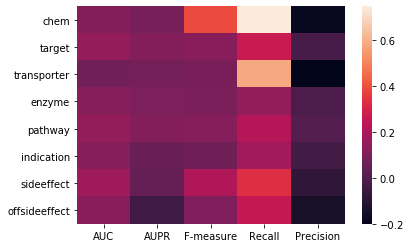

In [51]:
from seaborn import heatmap
heatmap(df_diff, yticklabels=df_paperIndividualScores["Similarity"])

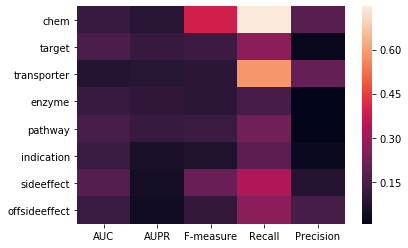

In [52]:
heatmap(df_diff_abs, yticklabels=df_paperIndividualScores["Similarity"])

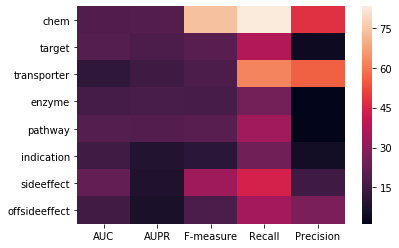

In [53]:
heatmap(df_diff_percent, yticklabels=df_paperIndividualScores["Similarity"])

In [54]:
from sklearn.metrics import mean_squared_error
mean_squared_error(df_paperIndividualScores[diff_metrics],
                   df_replicatedIndividualScores[diff_metrics])

0.0453187